<a href="https://colab.research.google.com/github/lbrogna/drone-palms/blob/main/write_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook will detail the process of utilizing convolutional neural networks pretrained using drone imagery to differentiate oil palms from surrounding land cover types.

The orthophotos used in this demonstration were procured by Lyndon Estes (LEstes@clarku.edu) for use in his GIS research and teaching. The models were trained by various groups led by Professor Estes, with special recognition to Hanxi Li (xiaoxi.steve@gmail.com) for her work in this process. Code from both Dr. Estes and PhD candidate Sam Khallaghi (samkhallaghy@gmail.com) was referenced in the process of building these notebooks.

This walkthrough was authored by Luke Brogna (lukebrogna@gmail.com). The computing was done in two sister notebooks entitled 'chip_unchip.ipynb' and 'palm_predict.ipynb', which can be found in the same repository that this notebook was found in.

All functions mentioned and not mentioned can be found in the other notebooks. They are commented for ease of understanding, and can be referenced for more technical information and gritty details.

In [ ]:
# @title
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# I. Chipping

The drone-collected imagery comes in the form of large orthophotos.

Below is an example of a full sized raw orthophoto.

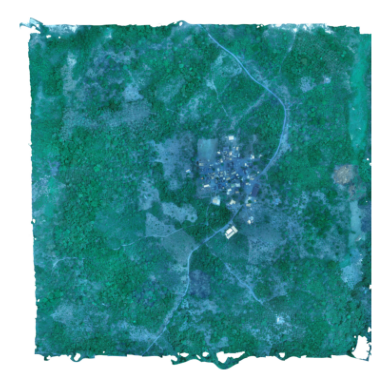

In [ ]:
# @title
image_path = '/content/drive/MyDrive/drone_working/ex_imgs/ortho1.png'

image = mpimg.imread(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

In order for these images to be processed by the model in an efficient way, they must be broken up into smaller pieces, commonly referred to in the field of GIS as "chips."

Each chip must be the same size and shape so that they may be fed into the model all at once.

Below is a function from 'chip_unchip.ipynb' that calculates the height, width, and overlaps each chip should have given the dimensions of the original image and the desired number of chips that the image should be broken down into.



```
def calculate_chips(image_width, image_height, num_chips):

    # calculate area of image
    image_area = image_width * image_height

    # calculate length of each side of a single chip
    chip_side_length = m.sqrt(image_area / num_chips)

    # calculate area of a single chip
    chip_area = m.sqrt(image_area / num_chips)

    # calculate number of chips in each dimension
    num_chips_per_dim = m.sqrt(num_chips)

    # calculate size of each chip
    chip_width = m.ceil(image_width / num_chips_per_dim)
    chip_height = m.ceil(image_height / num_chips_per_dim)

    # calculate overlap of each chip
    overlap_x = chip_width - chip_side_length
    overlap_y = chip_height - chip_side_length

    return chip_width, chip_height, m.ceil(overlap_x), m.ceil(overlap_y)
```



The calculated chip dimensions can then be used as inputs in a different function called 'chip_tif' which does the actual work of cutting the image up into pieces.

```
def chip_tif(input_file, num_chips, scale, square):

    # scale : param specifying down/upscaling factor as decimal percentage
    # square : boolean, whether or not to make the image a square

    # input image
    image = cv2.imread(input_file, cv2.IMREAD_COLOR)

    height = image.shape[:2][0]
    width = image.shape[:2][1]

    if square == 1:
      max_dim = min(height, width)
      image = image[0:max_dim, 0:max_dim]
      dim = (int(max_dim * scale), int(max_dim * scale)) #up/downscaling
    else:
      dim = (int(width * scale), int(height * scale)) #up/downscaling

    image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    # save original dimensions for future remosaicking
    old_dims = image.shape[:2]

    # get image dimensions
    height, width = image.shape[:2]

    # calculate chips using previously defined function
    chip_width, chip_height, overlap_x, overlap_y = calculate_chips(width, height, num_chips)

    # create list to store the chips
    chips = []

    index = 0
    indices = []

    for i in range(0, height - chip_height + 1, chip_height - overlap_y):
        for j in range(0, width - chip_width + 1, chip_width - overlap_x):
            chip = image[i:i+chip_height, j:j+chip_width]
            chips.append(chip)

    return chips, (overlap_y, overlap_x), (chip_height, chip_width), old_dims
```



In this exercise, 49 chips were obtained from each orthophoto. Below is one of those chips.

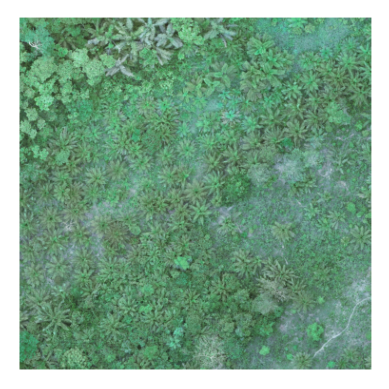

In [ ]:
# @title
image_path = '/content/drive/MyDrive/drone_working/ex_imgs/chip_ex.png'

image = mpimg.imread(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

The chips are then saved to be used in the next notebook which will run them through the model.

# II. Predicting

Now that the images have been chopped into more usable pieces, the process of loading the model and using it to generate predictions can begin. This code can be found in the 'palm_predict.ipynb' notebook.

The models in this project used the PyTorch library.

To compile the model, a Model Compiler class was defined with functions that would allow for loading parameters and generating predictions. Additionally, classes for model layers and the UNet model itself were defined. For brevity, these haven't been included in this write-up, but they can be viewed in the accompanying notebook for those interested, along with a text-based visualisation of the UNet used.

The means and standard deviations of the model weights, stored as '.pkl' files, were read in using the following code:
```
with open(means_filepath, "rb") as means_file:
    means = tuple(pkl.load(means_file))

with open(stds_filepath, "rb") as stds_file:
    stds = tuple(pkl.load(stds_file))
```

After this, the model was compiled with the parameters used to generate the pretrained weights, which themselves were then passed to initialize the model's parameters:


```
model = unet(config["img_bands"], config["class_numbers"], config["drop_rate"])

model_compiler = ModelCompiler(
    model=model,
    buffer=config["buffer"],
    gpuDevices=config["gpus"],
    params_init=config['init_params'],
    freeze_params=["freeze_params"])

model_compiler.load_params('/content/drive/MyDrive/drone_working/chkpt/4_checkpoint.pth.tar', freeze_params=None)
```

To generate a prediction, this code was run on each orthophoto's batch of chips:


```
thresh = 0.5  # minimum value for soft prediction that will be rounded to 1 when made hard

preds = []
imgs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

chip_files = [f for f in os.listdir(chips_path) if f.endswith(('.tif'))]

for chip in chip_files:

    out_name = chip[0:-4] + '_pred'

    img_file = chips_path + '/' + chip
    img, meta = load_data(img_file, normalize=True, means=means, stds=stds)
    imgs.append(img)
    img = np.expand_dims(img, 0).transpose(0, 1, 3, 2)
    img = torch.from_numpy(img).to(device)
    img = img.float()

    model = model_compiler.model
    model = model.to(device)
    model.eval()
    img = Variable(img, requires_grad=False)

    pred = model(img)
    pred_prob = F.softmax(pred, 1)

    nodata = -32768 if meta["dtype"] == "int16" else np.nan

    meta.update(nodata=nodata, count=1)
    meta["nodata"] = -1

    soft_prediction = pred_prob[:, 1, :, :].cpu().detach().numpy()
    highest_suit = max(max(soft_prediction).flatten())
    soft_prediction = soft_prediction / highest_suit
    hard_prediction = np.zeros_like(soft_prediction)
    hard_prediction[soft_prediction >= thresh] = 1
    hard_prediction = np.transpose(hard_prediction, [0, 2, 1])
    preds.append(hard_prediction)

    # Save the numpy array to the specified file path
    np.save(pred_dir + f"/hard_{out_name}", hard_prediction)
```

The prediction chips are saved directly, as numpy arrays ('.npy'). These can easily be displayed using code that looks something like this:


```
pred_chip = np.load('/content/drive/MyDrive/drone_working/test/hard_chip_47_pred.npy')
channel = pred_chip.squeeze()
plt.imshow(channel, cmap='viridis')
plt.axis('off')
plt.show()
```



It is worth noting that because the goal of this demonstration was to output a "hard" or binary prediction, the "soft" or continuous output of the model had to be converted using some threshold. This is the purpose of the user-modifiable 'thresh' variable. The value of each pixel in the resulting predictions is converted to either a 1 or a 0 depending on whether it falls above or below this threshold.

To illustrate why this is important, here are three "hard" predictions of the same chip generated using varying values for 'thresh':

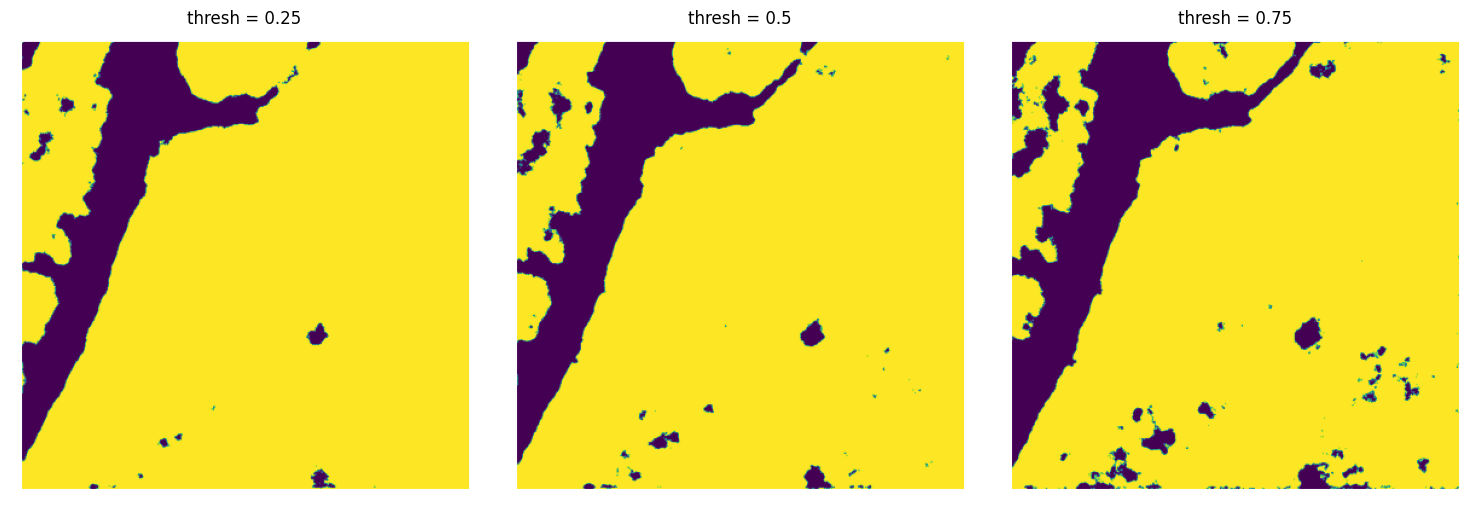

In [ ]:
# @title
image_paths = ['/content/drive/MyDrive/drone_working/ex_imgs/thresh_ex_25.png', '/content/drive/MyDrive/drone_working/ex_imgs/thres_ex_50.png', '/content/drive/MyDrive/drone_working/ex_imgs/thresh_ex_75.png']
image_labels = ['thresh = 0.25', 'thresh = 0.5', 'thresh = 0.75']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, image_path, label in zip(axes, image_paths, image_labels):
    image = mpimg.imread(image_path)
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

And here is the corresponding image chip for reference:

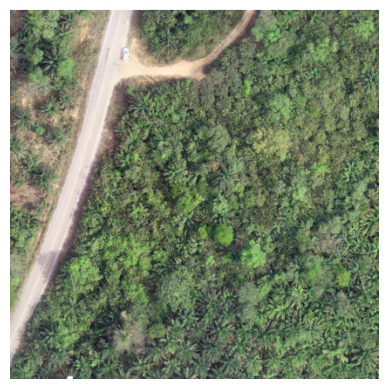

In [ ]:
# @title
image_path = '/content/drive/MyDrive/drone_working/ex_imgs/thresh_ex_chip.png'

image = mpimg.imread(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

In the prediction generated with the lower threshold value, the model diagnoses presence only where it is very sure (i.e. high "soft" output values). Following this, the higher threshold output seems to be worse at handling fog, clouds, and other areas where the model tends to be more uncertain.

This is only an eye-test, however.

To truly settle on an optimal threshold value for conversion to hard output, labelled data must be evaluated against the predictions at different thresholds using ROC curves or similar tools (i.e. TOC). A suitable threshold value could then be chosen with the goal that the prediction is trying to achieve in mind.

That said, that kind of analysis isn't within the scope of this demonstration. A threshold value of 0.5 was utilized for converting all the predictions from soft to hard, for no reason other than that it falls in the center of the continuum. The decision on that specific value was arbitrary.

# III. Remosaicking

The only step left is to reconstruct the larger images by putting each prediction chip back in the right place. Here is the function:


```
def remosaic(chips, image_shape, chip_dimensions, overlap, bands):
    # get image dimensions
    height, width = image_shape

    # initialize an empty canvas to reconstruct the image
    remosaicked_img = np.zeros((bands, height, width), dtype=np.float32)

    overlap_counts = np.zeros((height, width), dtype=np.uint8)

    # calculate the overlap between chips
    overlap_y, overlap_x = overlap

    # parse chip dims into seperate vars
    chip_h, chip_w = chip_dimensions

    # calculate the number of chips in each direction
    num_chips_y = int(np.ceil(height / chip_h))
    num_chips_x = int(np.ceil(width / chip_w))

    # reconstruct the image by placing each chip in the correct location
    chip_idx = 0

    for i in range(num_chips_y):
        for j in range(num_chips_x):
            y_start = i * (chip_h - overlap_y)
            y_end = min(y_start + chip_h, height)

            x_start = j * (chip_w - overlap_x)
            x_end = min(x_start + chip_w, width)

            chip = chips[chip_idx]

            # accumulate the chip into the reconstructed image
            remosaicked_img[:, y_start:y_end, x_start:x_end] += chip[:, :y_end-y_start, :x_end-x_start]
            overlap_counts[y_start:y_end, x_start:x_end] += 1

            chip_idx += 1
            if chip_idx >= len(chips):
                break
        if chip_idx >= len(chips):
            break

    overlap_counts = np.expand_dims(overlap_counts, axis=0)

    # average the overlapping regions
    remosaicked_img /= np.maximum(overlap_counts[...], 1)

    # convert the image back to uint8 data type
    remosaicked_img = np.round(remosaicked_img).astype(np.uint8)



    return remosaicked_img
```

There is also a slightly modified version of this function contained in 'chip_unchip.ipynb' which reconstructs orthophotos from image chips (that's the 'unchip' part).

Now this can be run for every batch of prediction chips:


```
remosaicked_img = remosaic(preds, image_shape, chip_dimensions, overlap, bands)

np.save(ri_filepath, remosaicked_img)
```
Again, the final output is saved as a '.npy' array which can be manipulated into the desired file type, or displayed using above-mentioned code (the output of which can then be saved as an image, if using a notebook-style interface).

# IV. Results

Five orthophotos were put through the processes explained above, here are the original images:

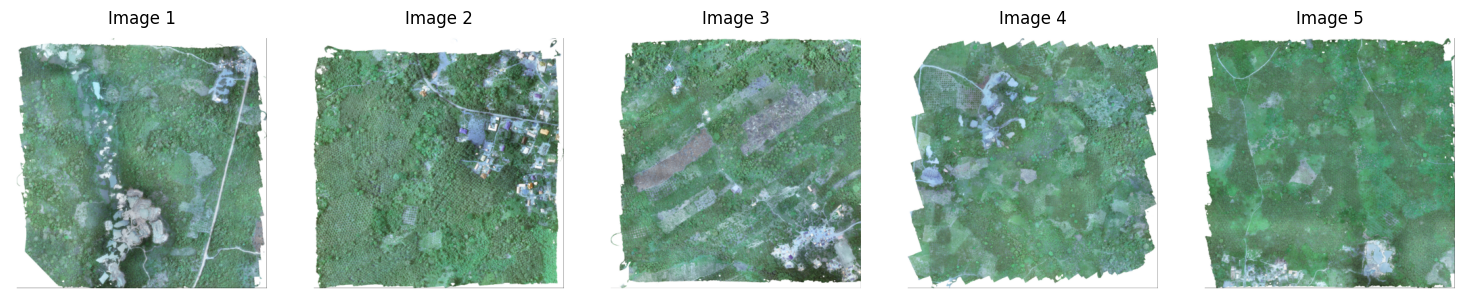

In [ ]:
# @title
image_paths = ['/content/drive/MyDrive/drone_working/ex_imgs/ortho0.png', '/content/drive/MyDrive/drone_working/ex_imgs/ortho2.png', '/content/drive/MyDrive/drone_working/ex_imgs/ortho3.png', '/content/drive/MyDrive/drone_working/ex_imgs/ortho4.png', '/content/drive/MyDrive/drone_working/ex_imgs/ortho5.png']

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, (ax, image_path) in enumerate(zip(axes, image_paths)):
    image = mpimg.imread(image_path)
    ax.imshow(image)
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

And here are the results:

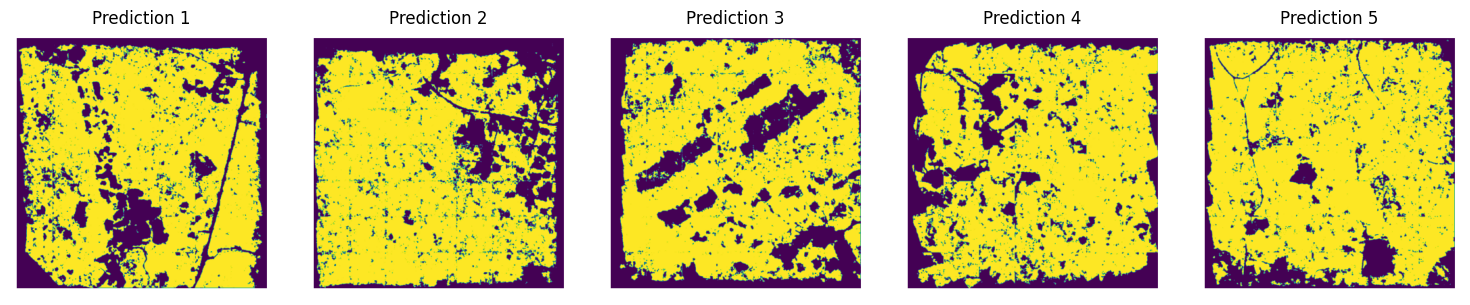

In [ ]:
# @title
image_paths = ['/content/drive/MyDrive/drone_working/ex_imgs/ortho0pred.png', '/content/drive/MyDrive/drone_working/ex_imgs/ortho2pred.png', '/content/drive/MyDrive/drone_working/ex_imgs/ortho3pred.png', '/content/drive/MyDrive/drone_working/ex_imgs/ortho4pred.png', '/content/drive/MyDrive/drone_working/ex_imgs/ortho6pred.png']

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, (ax, image_path) in enumerate(zip(axes, image_paths)):
    image = mpimg.imread(image_path)
    ax.imshow(image)
    ax.set_title(f'Prediction {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Thank you for reading this notebook.

For further questions or comments contact: lukebrogna@gmail.com.